# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - **Sobel**, **Prewitt**, **Roberts** - przypomnienie,
    - **Laplasjan z Gaussa** (LoG – ang. _Laplacian of Gaussian_),
    - **Canny**.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (_gradient_) i drugiej (_Laplasjan_) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}},
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$,
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne...". W jej wyniku następuje rozmazanie obrazu.
Laplasjan tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}.
\end{equation}

Funkcję (z oczywistych powodów) nazywamy _Laplasjanem z Gaussa_ (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt, jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

1. Wczytaj obraz *dom.png*.
2. Wykonaj rozmycie Gaussowskie obrazu wejściowego.
W tym celu wykorzystaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejściowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. `(3, 3)`).
Trzecim argumentem jest odchylenie standardowe. Wartość jest dobrana automatycznie, jeśli zostanie podana wartość `0` (będzie równa rozmiarowi).
3. Oblicz Laplasjan obrazu rozmytego.
W tym celu wykorzystaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierwszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.
4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik. Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej). W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$. Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wartości utworzonej tablicy do $<0, 255>$.
    - Wykonaj progowanie tablicy. Próg jest argumentem wejściowym (`thr`).
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku. Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`. Pierwszym argumentem jest obraz wejściowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.
5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, aby widoczne były kontury domu, ale nie dachówki.

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import requests

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/'
fileNames = ["dom.png"]

for fileName in fileNames:
    if not os.path.exists(fileName):
        r = requests.get(url + fileName, allow_redirects=True)
        open(fileName, 'wb').write(r.content)

In [2]:
# funkcja wykrywająca krawędzie z wykorzystaniem Laplasjanu z Gaussa
def crossing(LoG, thr):
    H, W = LoG.shape
    res = np.zeros_like(LoG)

    for i in range(1, H-1):
        for j in range(1, W-1):
            neigh = LoG[i-1:i+2, j-1:j+2]
            max_n = np.max(neigh)
            min_n = np.min(neigh)

            if max_n >= 0 and min_n < 0 or max_n < 0 and min_n >= 0:
                if LoG[i, j] > 0:
                    res[i, j] = LoG[i, j] + np.abs(min_n)
                elif LoG[i, j] < 0:
                    res[i, j] = np.abs(LoG[i, j]) + max_n

    res = cv2.normalize(res, None, 0, 255, cv2.NORM_MINMAX)
    _, res = cv2.threshold(res, thr, 255, cv2.THRESH_BINARY)
    res = res.astype(np.uint8)
    res = cv2.medianBlur(res, 3)

    return res

(-0.5, 556.5, 416.5, -0.5)

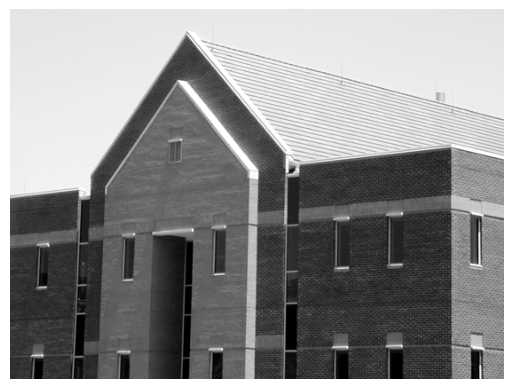

In [3]:
# wczytanie obrazu
dom = cv2.imread('dom.png', cv2.IMREAD_GRAYSCALE)

# wyświetlmy wczytany obraz
plt.imshow(dom, 'gray', vmin=0, vmax=256)
plt.axis('off')

(-0.5, 556.5, 416.5, -0.5)

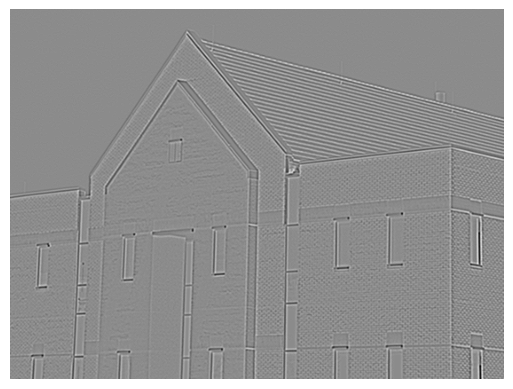

In [4]:
# rozmycie Gaussowskie
domBlur = cv2.GaussianBlur(dom, (3, 3), 0)

# laplasjan rozmytego obrazu
domBlurLap = cv2.Laplacian(domBlur, cv2.CV_32F)

# wyświetlmy laplasjan
plt.imshow(domBlurLap, 'gray')
plt.axis('off')

(-0.5, 556.5, 416.5, -0.5)

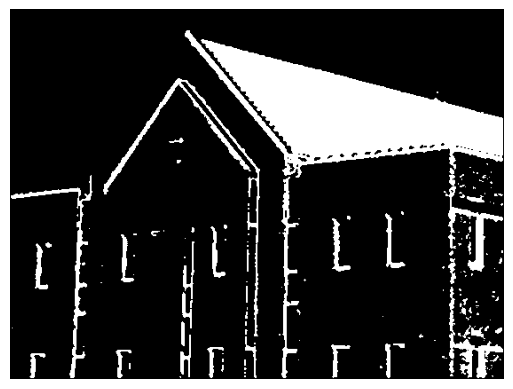

In [5]:
# przykładowy próg binaryzacji
thr = 50

# rezultat dla wybranych parametrów
result = crossing(domBlurLap, thr)

# wyświetlmy rezultat
plt.imshow(result, 'gray')
plt.axis('off')

(-0.5, 556.5, 416.5, -0.5)

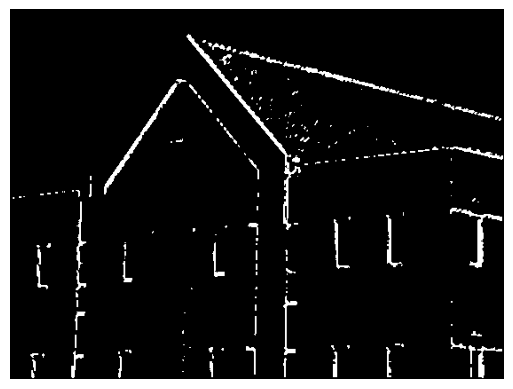

In [6]:
# znalezione parametry, dla których uzyskano pożądany efekt
kSize = (7, 7)
sigma = 1.25
thr = 80

blur = cv2.GaussianBlur(dom, kSize, sigma)
blurLap = cv2.Laplacian(blur, cv2.CV_32F)
result = crossing(blurLap, thr)

# wyświetlmy rezultat
plt.imshow(result, 'gray')
plt.axis('off')

## Algorytm Canny'ego

> Algorytm Canny'ego to często wykorzystywana metoda detekcji krawędzi.
> Zaproponowana została w 1986r. przez Johna F. Canny'ego.
> Przy jego projektowaniu założono trzy cele:
> - niska liczba błędów - algorytm powinien znajdować wszystkie krawędzie oraz generować jak najmniej fałszywych detekcji,
> - punkty krawędziowe powinny być poprawnie lokalizowane - wykryte punkty powinny być jak najbardziej zbliżone do rzeczywistych,
> - krawędzie o szerokości 1 piksela - algorytm powinien zwrócić **jeden punkt** dla każdej rzeczywistej krawędzi.

Zaimplementuj algorytm detekcji krawędzi Canny'ego:
1. W pierwszym kroku obraz przefiltruj dwuwymiarowym filtrem Gaussa.
2. Następnie oblicz gradient pionowy i poziomy ($g_x $ i $g_y$).
Jedną z metod jest _filtracja Sobela_.
3. Dalej oblicz amplitudę:
$M(x, y)  = \sqrt{g_x^2+g_y^2}$ oraz kąt:
$\alpha(x, y) = arctan(\frac{g_y}{g_x})$.
Do obliczenia kąta wykorzystaj funkcję `np.arctan2(x1, x2)`.
Wynik jest w radianach.
4. W kolejnym etapie wykonaj kwantyzację kątów gradientu.
Kąty od $-180^\circ$ do $180^\circ$ można podzielić na 8 przedziałów:
  - [$-22.5^\circ, 22.5^\circ$],
  - [$22.5^\circ, 67.5^\circ$],
  - [$67.5^\circ, 112.5^\circ$],
  - [$112.5^\circ, 157.5^\circ$],
  - [$157.5^\circ, -157.5^\circ$],
  - [$-157.5^\circ, -112.5^\circ$],
  - [$-112.5^\circ, -67.5^\circ$],
  - [$-67.5^\circ, -22.5^\circ$].

  Należy przy tym rozpatrywać tylko 4 kierunki:
  - pionowy ($d_1$),
  - poziomy ($d_2$),
  - skośny lewy ($d_3$),
  - skośny prawy ($d_4$).
5. Dalej przeprowadź eliminację pikseli, które nie mają wartości maksymalnej (ang. *nonmaximal suppression*).
Celem tej operacji jest redukcja szerokości krawędzi do rozmiaru 1 piksela.
Algorytm przebiega następująco - w rozpatrywanym otoczeniu o rozmiarze $3 \times 3$:
    - określ, do którego przedziału należy kierunek gradientu piksela centralnego ($d_1, d_2, d_3, d_4$),
    - przeanalizuj sąsiadów leżących na tym kierunku.

  Jeśli choć jeden z nich ma amplitudę większą niż piksel centralny, to należy uznać, że nie jest lokalnym maksimum i do wyniku przypisać $g_N(x,y) = 0$.
  W przeciwnym przypadku $g_N(x,y) = M(x,y)$.
  Przez $g_N$ rozumiemy obraz detekcji lokalnych maksimów.
  Zaimplementuj funkcję `nonmax`.
  Pierwszym argumentem jest macierz kierunków (po kwantyzacji).
  Drugim argumentem jest macierz amplitudy.
  
6. Ostatnią operacją jest binaryzacja obrazu $g_N$.
Stosuje się tutaj tzw. **binaryzację z histerezą**.
Wykorzystuje się w niej dwa progi: $T_L$ i $T_H$, przy czym $T_L < T_H$.
Canny zaproponował, aby stosunek progu wyższego do niższego był jak 3 lub 2 do 1.
Rezultaty binaryzacji można opisać jako:<br>
$g_{NH}(x,y) = g_N(x,y) \geq TH $<br>
$g_{NL}(x,y) = TH > g_N(x,y) \geq TL $<br>
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
Często krawędzie "pewne" nie są ciągłe.
Dlatego wykorzystuje się obraz $g_{NL}$ w następującej procedurze:
    - Stwórz stos zawierający wszystkie piksele zaznaczone na obrazie $g_{NH}$.
W tym celu wykorzystaj listę współrzędnych `[row, col]`.
Do pobrania elementu z początku służy metoda `list.pop()`.
Do dodania elementu na koniec listy służy metoda `list.append(new)`.
    - Stwórz obraz, który będzie zawierał informację, czy dany piksel został już odwiedzony.
    - Stwórz obraz, który zawierać będzie wynikowe krawędzie.
Jego rozmiar jest równy rozmiarowi obrazu.
    - Wykonaj pętlę, która będzie pobierać elementy z listy, dopóki ta nie będzie pusta.
W tym celu najlepiej sprawdzi się pętla `while`.
    - W każdej iteracji pobierz element ze stosu.
    - Sprawdź, czy dany element został już odwiedzony.
    - Jeśli nie został odwiedzony, to:
        - oznacz go jako odwiedzony,
        - oznacz piksel jako krawędź w wyniku,
        - sprawdź otoczenie piksela w obrazie $g_{NL}$,
        - dodaj do stosu współrzędne otoczenia, które zawierają krawędź (potencjalną). Można to wykonać np. pętlą po stworzonym otoczeniu.

7. Wyświetl obraz oryginalny, obraz $g_{NH}$ oraz obraz wynikowy.

Pomocnicze obrazy $g_{NH}$ i $g_{NL}$ zostały wprowadzone dla uproszczenia opisu.
Algorytm można zaimplementować w bardziej "zwarty" sposób.

Na podstawie powyższego opisu zaimplementuj algorytm Cannego.

In [7]:
# nonmaximal suppression
def nonmax(K, M):
    H, W = K.shape
    gn = np.zeros_like(M)

    for i in range(1, H-1):
        for j in range(1, W-1):
            direction = K[i, j]
            
            if direction == 1:
                n1, n2 = (i-1, j), (i+1, j)
            elif direction == 2:
                n1, n2 = (i, j-1), (i, j+1)
            elif direction == 3:
                n1, n2 = (i-1, j-1), (i+1, j+1)
            else:
                n1, n2 = (i+1, j-1), (i-1, j+1)

            if M[n1] <= M[i, j] and M[n2] <= M[i, j]:
                gn[i, j] = M[i, j]

    return gn

In [8]:
# wykorzystanie binaryzacji obrazu gn - serce algorytmu
def detect_edges(gnh, gnl):
    visited = np.zeros_like(gnh)
    edges = np.zeros(gnh.shape, dtype=np.uint8)
    stack = []

    for i, row in enumerate(gnh):
        for j, val in enumerate(row):
            if val:
                stack.append((i, j))

    while stack:
        i, j = stack.pop()

        if not visited[i, j]:
            visited[i, j] = True
            edges[i, j] = 1
            
            for y in range(i-1, i+2):
                for x in range(j-1, j+2):
                    if gnl[y, x]:
                        stack.append((y, x))

    return edges

In [9]:
# przefiltrowanie dwuwymiarowym filtrem Gaussa
domBlur = cv2.GaussianBlur(dom, (3, 3), 0)

# obliczanie gradientów
gx = cv2.Sobel(domBlur, cv2.CV_32F, 1, 0)
gy = cv2.Sobel(domBlur, cv2.CV_32F, 0, 1)

# obliczenie amplitudy i kąta
M = np.sqrt(gx ** 2 + gy ** 2)
alpha = np.arctan2(gy, gx)

In [10]:
# kwantyzacja kątów gradientu
directions_mapping = np.array([2, 3, 1, 4], dtype=np.uint8)
alpha_quantized = np.round((alpha + np.pi) / (np.pi / 4)).astype(np.uint8) % 4
K = directions_mapping[alpha_quantized]

In [11]:
# eliminacja pikseli, które nie mają wartości maksymalnej
gn = nonmax(K, M)

# przyjęte progi do binaryzacji z histerezą
Tl = 50
Th = 150

# pomocnicze obrazy
gnh = gn >= Th
gnl = np.logical_and(Th > gn, gn >= Tl)

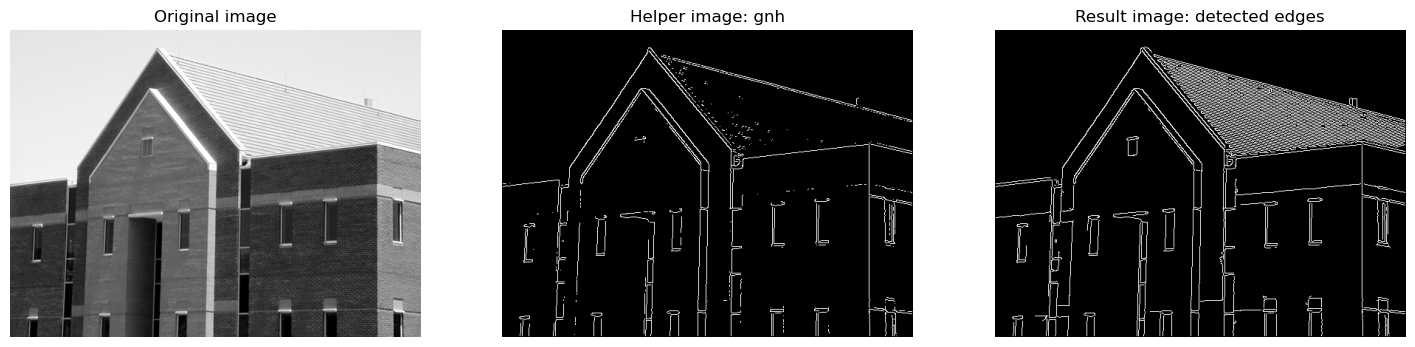

In [12]:
# wyznaczenie krawędzi algorytmem Cannego
edges = detect_edges(gnh, gnl)

# wyświetlmy wyniki i porównanie
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(18, 6)

axs[0].set_title("Original image")
axs[0].imshow(dom, 'gray', vmin=0, vmax=256)
axs[0].axis('off')

axs[1].set_title("Helper image: gnh")
axs[1].imshow(gnh, 'gray')
axs[1].axis('off')

axs[2].set_title("Result image: detected edges")
axs[2].imshow(edges, 'gray')
axs[2].axis('off')

plt.show()

## Algorytm Canny'ego - OpenCV

1. Wykonaj detekcję krawędzi metodą Canny'ego, wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy,
    - Drugim argumentem jest mniejszy próg,
    - Trzecim argumentem jest większy próg,
    - Czwarty argument to tablica, do której wpisany zostanie wynik. Można zwrócić go przez wartość i podać wartość `None`,
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3),
    - Szósty argument to rodzaj używanej normy. 0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z własną implementacją.

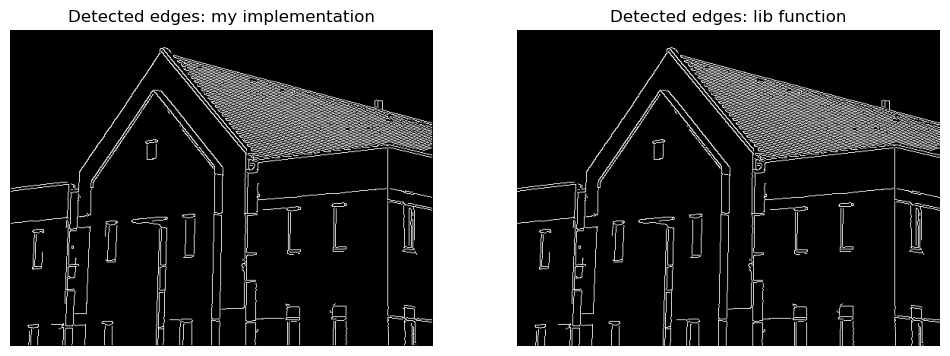

In [13]:
# wykorzystanie funkcji bibliotecznej
edgesLib = cv2.Canny(domBlur, Tl, Th, None, 3, 1)

# porównanie
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 6)

axs[0].set_title("Detected edges: my implementation")
axs[0].imshow(edges, 'gray')
axs[0].axis('off')

axs[1].set_title("Detected edges: lib function")
axs[1].imshow(edgesLib, 'gray')
axs[1].axis('off')

plt.show()